In [17]:
__Author__ = 'Firas Obeid'

In [1]:
# Install the required libraries
!pip install prophet

Libraries successfully installed


[Simple Model Approach](https://sarem-seitz.com/posts/winning-with-simple-not-even-linear-time-series-models/)

In [1]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
from prophet import Prophet

%matplotlib inline

In [3]:
# Upload the sp500.csv file
from google.colab import files
uploaded = files.upload()

Saving bitcoin_hourly.csv to bitcoin_hourly.csv


In [2]:
# Read csv file as DataFrame, with the first column as row index
df = pd.read_csv("../Resources/sp500.csv",
                 index_col="time",
                 infer_datetime_format=True,
                 parse_dates=True
                )

# Remove the timezone from the index for Prophet compatibility
df.index = df.index.tz_localize(None)

# Preview the dataset
df.head()

,close
time,
2019-01-02 12:45:00,246.16
2019-01-02 13:00:00,246.15
2019-01-02 13:15:00,245.50
2019-01-02 13:30:00,245.71
2019-01-02 13:45:00,245.76


<AxesSubplot:xlabel='time'>

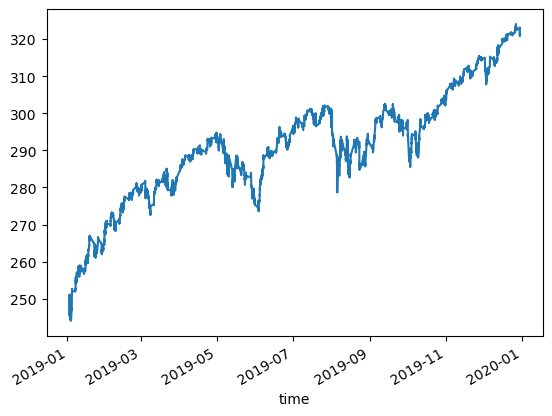

In [3]:
# Visually inspect the price data
df["close"].plot()

In [4]:
close = df["close"]
train = close.iloc[:-120]
test = close.iloc[-120:]

## Simple Model

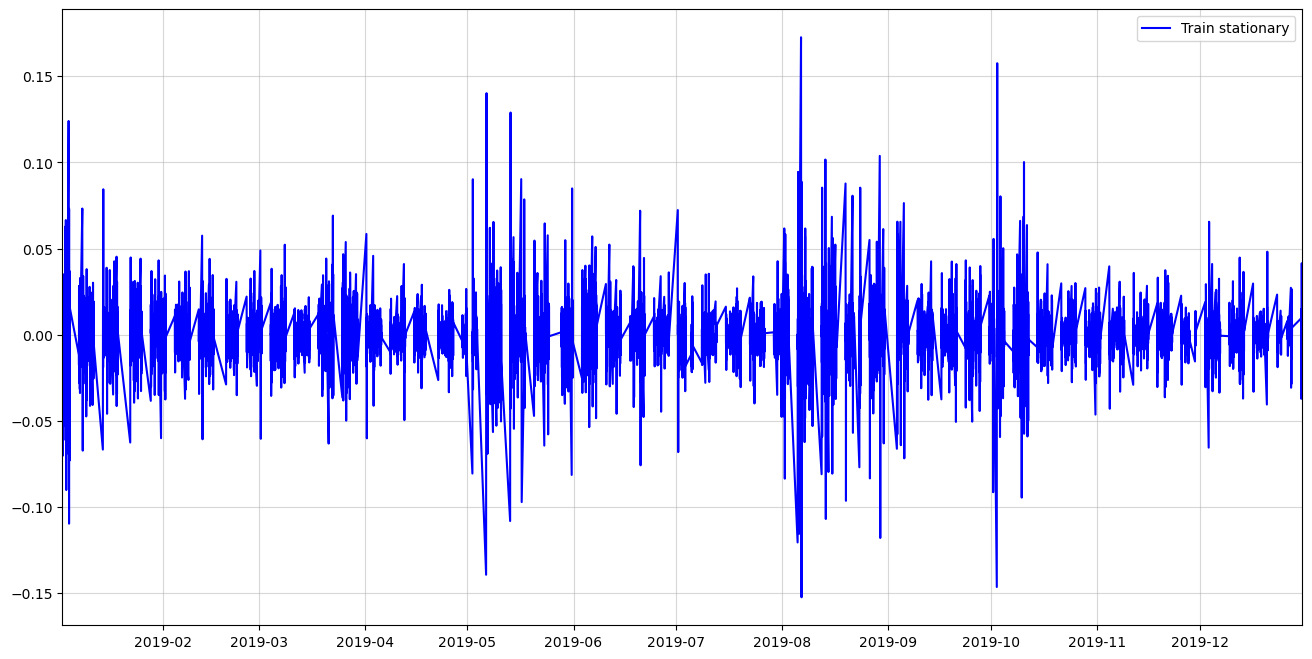

In [5]:
# Add whatever analysis and predictions you see fit
import numpy as np
import matplotlib.pyplot as plt
rooted = np.sqrt(df["close"])
diffed = rooted.diff(1)
diffed_s = diffed.diff(12).dropna()
plt.figure(figsize = (16,8))
plt.plot(diffed_s,color="blue",label="Train stationary")
plt.legend()
plt.margins(x=0)
plt.grid(alpha=0.5);

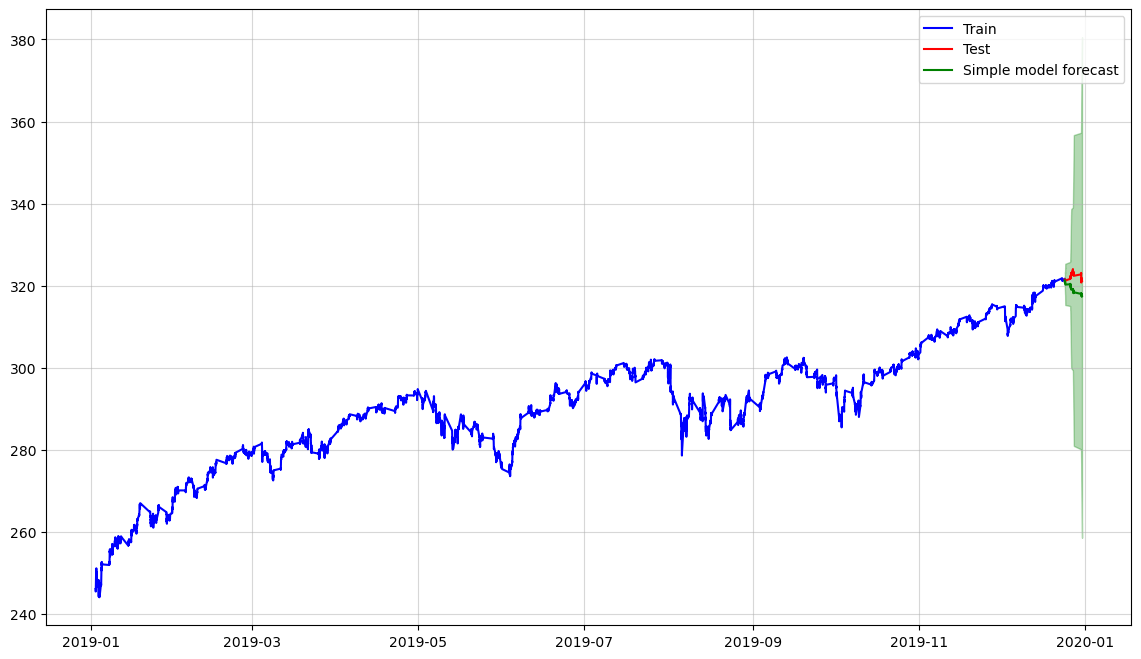

In [6]:

full_sample = [] 
np.random.seed(42)
for i in range(10000):
    draw = np.random.choice(diffed_s,len(test))
    result = list(diffed.iloc[-12:].values)
    for t in range(len(test)):
        result.append(result[t]+draw[t])
    full_sample.append(np.array(((rooted.iloc[-1])+np.cumsum(result[12:]))**2).reshape(-1,1))
    
reshaped = np.concatenate(full_sample,1)
result_mean = np.mean(reshaped,1)
lower = np.quantile(reshaped,0.05,1)
upper = np.quantile(reshaped,0.95,1)
plt.figure(figsize = (14,8))
plt.plot(train, label = "Train",color="blue")
plt.plot(test, label = "Test",color="red")
plt.grid(alpha = 0.5)
plt.plot(test.index, result_mean,label = "Simple model forecast",color="green")
plt.legend()
plt.fill_between(test.index,lower,upper,alpha=0.3,color="green");

## Prophet

In [7]:
train_proph = pd.DataFrame(train).reset_index()
train_proph.columns = ["ds","y"]
train_proph["unique_id"] = np.ones(len(train))

test_proph = pd.DataFrame(test).reset_index()
test_proph.columns = ["ds","y"]
test_proph["unique_id"] = np.ones(len(test))

In [8]:
model = Prophet()

In [9]:
model.fit(train_proph)

23:16:53 - cmdstanpy - INFO - Chain [1] start processing
23:16:58 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
forcast = model.make_future_dataframe(periods = len(test), freq="15m")

In [11]:
forecast_ = model.predict(forcast)
forecast_.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9323,2163-09-30 13:15:00,18593.988725,-315595.404958,341277.392072,-315594.616611,341276.390615,-0.927185,-0.927185,-0.927185,-1.008647,-1.008647,-1.008647,0.081462,0.081462,0.081462,0.0,0.0,0.0,18593.061540
9324,2164-12-31 13:15:00,18753.351285,-319088.600586,345528.645474,-319084.680569,345532.248112,-1.435161,-1.435161,-1.435161,-1.008647,-1.008647,-1.008647,-0.426514,-0.426514,-0.426514,0.0,0.0,0.0,18751.916124
9325,2166-03-31 13:15:00,18911.669986,-321854.697167,349895.248663,-321849.482115,349896.094532,-1.435161,-1.435161,-1.435161,-1.008647,-1.008647,-1.008647,-0.426514,-0.426514,-0.426514,0.0,0.0,0.0,18910.234825
9326,2167-06-30 13:15:00,19070.336640,-325553.648619,354330.134388,-325549.412039,354332.931502,-1.334159,-1.334159,-1.334159,-1.008647,-1.008647,-1.008647,-0.325512,-0.325512,-0.325512,0.0,0.0,0.0,19069.002481
9327,2168-09-30 13:15:00,19229.699200,-328353.993110,359163.323202,-328353.388121,359165.665603,-0.927185,-0.927185,-0.927185,-1.008647,-1.008647,-1.008647,0.081462,0.081462,0.081462,0.0,0.0,0.0,19228.772015


## Compare Models

In [12]:
rmse_simple = np.sqrt(np.mean((test.values-result_mean)**2))
rmse_prophet = np.sqrt(np.mean((test.values-forecast_['yhat'].iloc[-120:].values)**2)) 
pd.DataFrame([rmse_simple,rmse_prophet], index = ["Simple", "Prophet"], columns=["RMSE"])

,RMSE
Simple,3.492202
Prophet,10939.020050


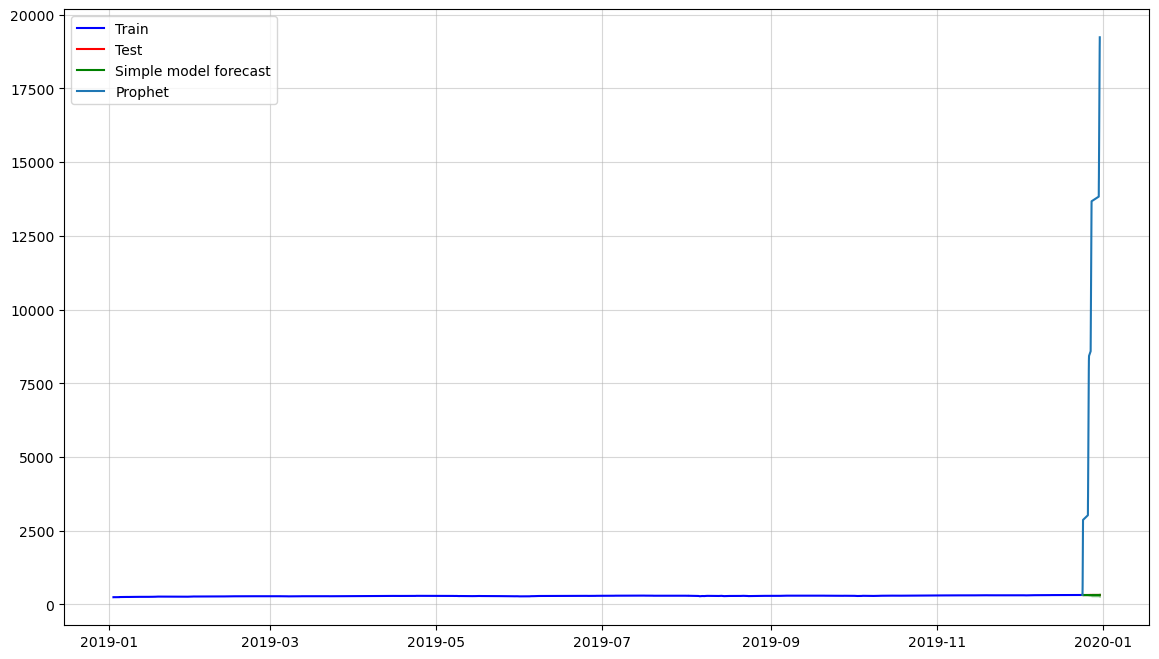

In [15]:
plt.figure(figsize = (14,8))
plt.plot(train, label = "Train",color="blue")
plt.plot(test, label = "Test",color="red")
plt.grid(alpha = 0.5)
plt.plot(test.index, result_mean,label = "Simple model forecast",color="green")
plt.plot(test.index, forecast_['yhat'].iloc[-120:].values,label = "Prophet")
plt.legend()
plt.fill_between(test.index,lower,upper,alpha=0.3,color="green");

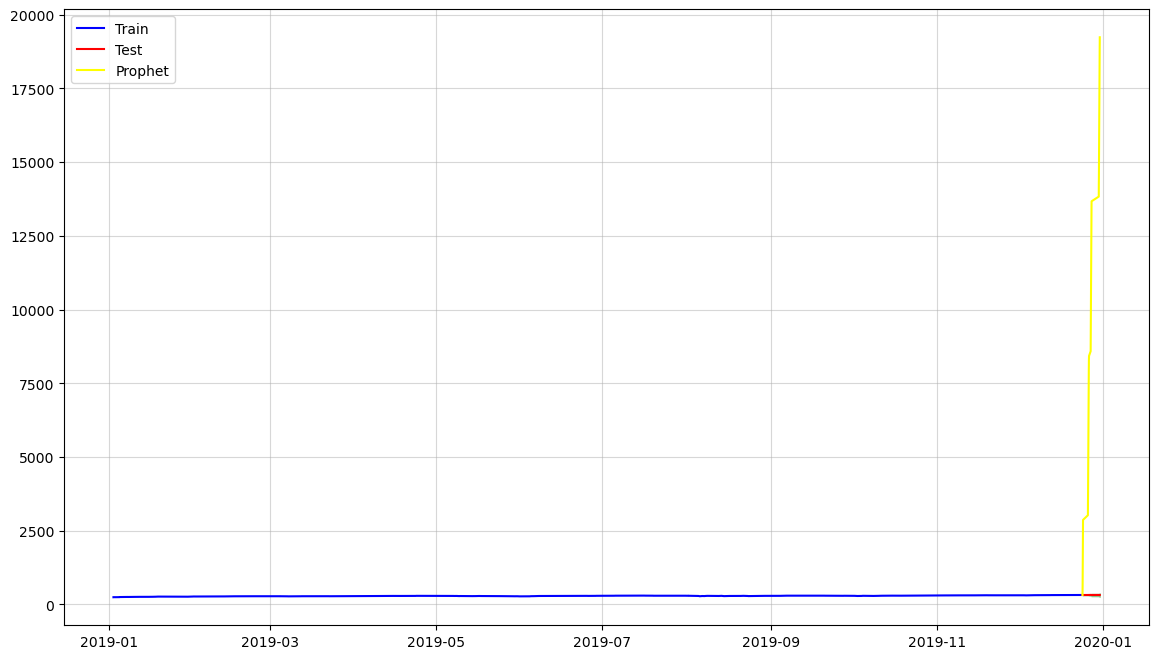

In [16]:
plt.figure(figsize = (14,8))
plt.plot(train, label = "Train",color="blue")
plt.plot(test, label = "Test",color="red")
plt.grid(alpha = 0.5)
plt.plot(test.index, forecast_['yhat'].iloc[-120:].values,label = "Prophet", color = 'yellow')
plt.legend()
plt.fill_between(test.index,lower,upper,alpha=0.3,color="green");